In [4]:
%matplotlib inline
import loader
import random
import numpy as np
import matplotlib.pyplot as plt
file = '2012-Consolidated-stripped.csv'

In [44]:
def reservoir_sample(iterator, k):
    """
    Basic reservoir sample. Takes a target sample amount
    """
    # fill the reservoir to start
    iterator = iter(iterator)
    result = [next(iterator) for _ in range(k)]
    n = k
    for item in iterator:
        n += 1
        s = random.randint(0, n)
        if s < k:
            result[s] = item
    return result


def get_sample_size(len1, len2, percent):
    return int(min(len1, len2) * percent)


# in hindsight, not sure we need this (since we care about magnitude) but it's here
def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

In [6]:
reload(loader)
rows = loader.load_raw(file)

In [7]:
chronic = []
not_chronic = []

for pid in rows:
    person = rows[pid]
    person_data = person.info
    chron = False
    all_pop = True
    for code in person.info:
        if 'chronic_'in code and not chron:
                if person_data[code] is 1:
                    chron = True
                elif person_data[code] is -9 or person_data[code] is -8 or person_data[code] is -7:
                    rows[pid].chronic = -1
            
    if chron:
        chronic.append(pid)
    else:
        not_chronic.append(pid)
    
    person.age = person_data['demo_age']
    
    if 'spending_dist_total' in person.info:
        person.spend = person_data['spending_dist_total']
    else:
        person.spend = 0
    
    if 'service_office' in person.info:
        person.office = person_data['service_office']
    else:
        person.office = 0
        
    if 'spending_dist_office' in person.info:
        person.officesp = person_data['spending_dist_office']
    else:
        person.officesp = 0

In [8]:
# calculate sample size
ssize = get_sample_size(len(chronic), len(not_chronic), 0.70)

# sample chronic and non-chronic
schron = reservoir_sample(chronic, ssize)
snot = reservoir_sample(not_chronic, ssize)

In [50]:
# get spend for each
schron_spend = [rows[pid].info['spending_dist_total'] for pid in schron]
snot_spend = [rows[pid].info['spending_dist_total'] for pid in snot]

In [51]:
print np.average(schron_spend), np.median(schron_spend), np.std(schron_spend)
print np.average(snot_spend), np.median(snot_spend), np.std(snot_spend)

6311.82609962 1679.0 15400.8390945
0.00373678420979 0.00099401672182 0.00911774365096
1418.98135741 190.0 9942.06147596
0.0013922710131 0.000186423515085 0.00975491603968


In [11]:
# get office visit for each
schron_office = [rows[pid].office for pid in schron]
snot_office = [rows[pid].office for pid in snot]

In [12]:
print(np.average(schron_office))
print(np.average(snot_office))

6.29022235168
2.0368967861


In [13]:
# get cost per visit for each
schron_cpv = [rows[pid].officesp/rows[pid].office for pid in schron if rows[pid].office>0]
snot_cpv = [rows[pid].officesp/rows[pid].office for pid in snot if rows[pid].office>0]

In [14]:
print(np.average(schron_cpv))
print(np.average(snot_office))

3.85223367698
2.0368967861


In [15]:
# breakdown in to age groups
chron_young, chron_mid, chron_old = [],[],[]
for pid in chronic:
    if rows[pid].age>18 and rows[pid].age<45:
        chron_young.append(pid)
    elif rows[pid].age>=45 and rows[pid].age<65:
        chron_mid.append(pid)
    elif rows[pid].age>=65:
        chron_old.append(pid)

notchron_young, notchron_mid, notchron_old = [],[],[]
for pid in not_chronic:
    if rows[pid].age>18 and rows[pid].age<45:
        notchron_young.append(pid)
    elif rows[pid].age>=45 and rows[pid].age<65:
        notchron_mid.append(pid)
    elif rows[pid].age>=65:
        notchron_old.append(pid)  

In [16]:
# sample for each age group
def sample_age_group(chron, notchron):
    ssize_age = get_sample_size(len(chron), len(notchron), 0.7)
    schron_age = reservoir_sample(chron, ssize_age)
    snotchron_age = reservoir_sample(notchron, ssize_age)
    return schron_age, snotchron_age

schron_young, snotchron_young = sample_age_group(chron_young, notchron_young)
schron_mid, snotchron_mid = sample_age_group(chron_mid, notchron_mid)
schron_old, snotchron_old = sample_age_group(chron_old, notchron_old)

In [17]:
print len(schron_young), len(schron_mid), len(schron_old)

2538 2408 320


In [18]:
# gspending
chron_young_sp = [rows[pid].spend for pid in schron_young]
chron_mid_sp = [rows[pid].spend for pid in schron_mid]
chron_old_sp = [rows[pid].spend for pid in schron_old]
notchron_young_sp = [rows[pid].spend for pid in snotchron_young]
notchron_mid_sp = [rows[pid].spend for pid in snotchron_mid]
notchron_old_sp = [rows[pid].spend for pid in snotchron_old]

In [19]:
print np.average(chron_young_sp), np.average(notchron_young_sp)
print np.average(chron_mid_sp), np.average(notchron_mid_sp)
print np.average(chron_old_sp), np.average(notchron_old_sp)

3678.26122931 1493.06185973
6852.41860465 1591.74750831
8631.871875 2897.496875


In [20]:
chron_young_ov = [rows[pid].office for pid in chronic if rows[pid].age>18 and rows[pid].age < 45]
chron_mid_ov = [rows[pid].office for pid in chronic if rows[pid].age>=45 and rows[pid].age < 65]
chron_old_ov = [rows[pid].office for pid in chronic if rows[pid].age>=65]
notchron_young_ov = [rows[pid].office for pid in not_chronic if rows[pid].age>18 and rows[pid].age < 45]
notchron_mid_ov = [rows[pid].office for pid in not_chronic if rows[pid].age>=45 and rows[pid].age < 65]
notchron_old_ov = [rows[pid].office for pid in not_chronic if rows[pid].age>=65]

In [21]:
print np.average(chron_young_ov), np.average(notchron_young_ov)
print np.average(chron_mid_ov), np.average(notchron_mid_ov)
print np.average(chron_old_ov), np.average(notchron_old_ov)

4.50523993381 1.86236261016
6.47518588968 2.3254867771
9.26730869339 3.75545851528


In [54]:
# race
chron_white = [pid for pid in chronic if rows[pid].info['demo_race_input'] is 1]
chron_black = [pid for pid in chronic if rows[pid].info['demo_race_input'] is 2]
chron_native = [pid for pid in chronic if rows[pid].info['demo_race_input'] is 3]
chron_asian = [pid for pid in chronic if rows[pid].info['demo_race_input'] is 4]
chron_pisland = [pid for pid in chronic if rows[pid].info['demo_race_input'] is 5]
chron_multiple = [pid for pid in chronic if rows[pid].info['demo_race_input'] is 6]

notchron_white = [pid for pid in not_chronic if rows[pid].info['demo_race_input'] is 1]
notchron_black = [pid for pid in not_chronic if rows[pid].info['demo_race_input'] is 2]
notchron_native = [pid for pid in not_chronic if rows[pid].info['demo_race_input'] is 3]
notchron_asian = [pid for pid in not_chronic if rows[pid].info['demo_race_input'] is 4]
notchron_pisland = [pid for pid in not_chronic if rows[pid].info['demo_race_input'] is 5]
notchron_multiple = [pid for pid in not_chronic if rows[pid].info['demo_race_input'] is 6]

def sample_race_group(chron, notchron):
    ssize_race = get_sample_size(len(chron), len(notchron), 0.7)
    schron_race = reservoir_sample(chron, ssize_race)
    snotchron_race = reservoir_sample(notchron, ssize_race)
    return schron_race, snotchron_race

schron_white, snotchron_white = sample_race_group(chron_white, notchron_white)
schron_black, snotchron_black = sample_race_group(chron_black, notchron_black)
schron_native, snotchron_native = sample_race_group(chron_native, notchron_native)
schron_asian, snotchron_asian = sample_race_group(chron_asian, notchron_asian)
schron_pisland, snotchron_pisland = sample_race_group(chron_pisland, notchron_pisland)
schron_multiple, snotchron_multiple = sample_race_group(chron_multiple, notchron_multiple)

# print len(schron_white), len(schron_black), len(schron_native), len(schron_asian), len(schron_pisland), len(schron_multiple)

chron_white_sp, notchron_white_sp = [rows[pid].spend for pid in schron_white], [rows[pid].spend for pid in snotchron_white] 
chron_black_sp, notchron_black_sp = [rows[pid].spend for pid in schron_black], [rows[pid].spend for pid in snotchron_black] 
chron_native_sp, notchron_native_sp = [rows[pid].spend for pid in schron_native], [rows[pid].spend for pid in snotchron_native] 
chron_asian_sp, notchron_asian_sp = [rows[pid].spend for pid in schron_asian], [rows[pid].spend for pid in snotchron_asian] 
chron_pisland_sp, notchron_pisland_sp = [rows[pid].spend for pid in schron_pisland], [rows[pid].spend for pid in snotchron_pisland] 
chron_multiple_sp, notchron_multiple_sp = [rows[pid].spend for pid in schron_multiple], [rows[pid].spend for pid in snotchron_multiple] 

print np.average(chron_white_sp), np.average(notchron_white_sp)
print np.average(chron_black_sp), np.average(notchron_black_sp)
print np.average(chron_native_sp), np.average(notchron_native_sp)
print np.average(chron_asian_sp), np.average(notchron_asian_sp)
print np.average(chron_pisland_sp), np.average(notchron_pisland_sp)
print np.average(chron_multiple_sp), np.average(notchron_multiple_sp)

6939.77466842 1434.91546422
5504.52922958 1622.39527681
6930.81 695.03
5586.76208897 1687.22243714
4560.76086957 1152.82608696
5578.17989418 1118.95238095


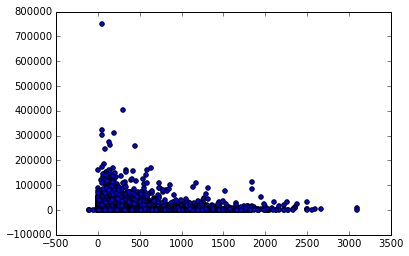

In [26]:
# income vs spending
schron_income = [rows[pid].info['demo_fam_income_pl'] for pid in schron]
snot_income = [rows[pid].info['demo_fam_income_pl'] for pid in snot]

income = schron_income + snot_income
spend = schron_spend + snot_spend

plt.scatter(schron_income, schron_spend)
plt.scatter(snot_income, snot_spend)